In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset


import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import os

#On prioritise l'utilisation du GPU si disponible
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

In [ ]:
train_data_raw=torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data_raw=torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor()) 


In [ ]:

class TripletFashionMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset=dataset
        self.train_labels = self.dataset.targets #les labels des images
        self.train_data = self.dataset.data #les images
        self.labels_set = set(self.train_labels.numpy())# ensemble des labels uniques
        self.label_to_indices = {label: np.where(self.train_labels.numpy() == label)[0]
                                 for label in self.labels_set} # dictionnaire label: indices des images avec ce label
        
    def __getitem__(self, index):
        #Anchor (référence)
        img1, label1 = self.dataset[index]
            
            #Positif avec le meme label
        positive_index = index
        while positive_index == index: #pour eviter de prendre la meme image
            positive_index = np.random.choice(self.label_to_indices[label1])
        img2, _ = self.dataset[positive_index]
            
            #Negatif avec un label different
        negative_label = np.random.choice(list(self.labels_set - set([label1]))) # choix d'un label different
        negative_index = np.random.choice(self.label_to_indices[negative_label]) #On prend une image avec ce label
        img3, _ = self.dataset[negative_index]
    
        return (img1, img2, img3) ,[] #le label n'est pas utilise dans le triplet loss

    def __len__(self): 
        return len(self.dataset) #nombre d'images dans le dataset
    
train_dataset = TripletFashionMNIST(train_data_raw)
train=DataLoader(train_dataset, batch_size=64, shuffle=True) 




Architechture CNN: l'objectif n'est pas de classer directement mais de compresser l'image pour en faire un vecteur de nombres (embedding) sur lequel on va pouvoir faire des opérations.

image de 28x28 pixels --> vecteur de 128 valeurs

In [9]:
class Embedding(nn.Module):
    def __init__(self):
        super(Embedding, self).__init__()
        # Réseau de neurones convolutifs
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 32, 5), #premiere couche convolutionnelle
            nn.ReLU(), #fonction d'activation non lineaire
            nn.MaxPool2d(2, 2), #couche de pooling pour reduire la taille
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # Couche entièrement connectée
        self.fc = nn.Sequential( 
            nn.Linear(64 * 4 * 4, 256), #réseau linéaire de taille adaptée à la sortie des convolutions
            nn.PReLU(), #fonction d'activation non lineaire
            nn.Linear(256, 256) ,
            nn.PReLU(),
            nn.Linear(256, 128) #réseau linéaire de sortie de taille 128
        )

    def forward(self, x):
        x = self.convnet(x) #passage par les couches convolutives, on obtient un cube de caractéristiques
        x = x.view(x.size()[0], -1) #aplatir la sortie pour la couche entièrement connectée
        x = self.fc(x) #passage par les couches entièrement connectées
        return x

Maintenant nous pouvons mettre en place le réseau Siamois 

In [39]:
class Siamois(nn.Module):
    def __init__(self, embedding=None):
        super(Siamois, self).__init__()
        if embedding is None:
            self.embedding = Embedding() #utilisation du réseau d'embedding défini par défaut
        else:
            self.embedding = embedding  #utilisation de l'embedding fourni en paramètre (utile pour le transfert d'apprentissage )

    def forward(self, x1, x2, x3):
        #On passe les trois images (ancre, positif, négatif) dans le même réseau d'embedding
        output1 = self.embedding(x1) #obtenir l'embedding de l'ancre
        output2 = self.embedding(x2) #obtenir l'embedding du positif
        output3 = self.embedding(x3) #obtenir l'embedding du négatif
        return output1, output2, output3
    
embedding=Embedding()
model = Siamois().to(device)

# Formule mathématique de la Triplet Loss

On veut que la distance d(ancre,positif) soit le plus petit possible tout en assurant que d(ancre,negatif) soit grande. En ajoutant une marge cette condition se traduit par la formule : 

$$ \Delta(A,P) - \Delta(A,N) +marge <0$$

Si cette condition est vérifié, la fonction de perte doit renvoyer 0 (car on est en dehor de la marge (comparaison avec les SVM)) Sinon la loss est positive et correspond à la valeur.

On définit alors une fonction de perte qui suit cette logique 

In [14]:
class TripletLoss(nn.Module):
    def __init__(self, marge=1.0):
        super(TripletLoss, self).__init__()
        self.marge = marge

    def forward(self, anchor, positive, negative):
        # Calcul des distances euclidiennes 
        distance_positive = (anchor - positive).pow(2).sum(1)  # Distance entre ancre et positif
        distance_negative = (anchor - negative).pow(2).sum(1)  # Distance entre ancre et négatif
        
        # Calcul de la perte triplet
        losses = torch.relu(distance_positive - distance_negative + self.marge) #relu vaut 0 si l'argument est négatif et l'argument sinon
        return losses.mean()
    

critere = TripletLoss(marge=1.0).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Lancement de la boucle d'entrainement 

In [18]:
epoches = 10
model.train()

for epoch in range(epoches):
    running_loss = 0.0 #perte cumulée pour l'affichage
    
    for batch_index, (data,_) in enumerate(train):
        (anchor, positive, negative)= data
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)#envoi des images au device (GPU)
        
        #remise à zero des gradients
        optimizer.zero_grad()
        
        
        anchor_out, positive_out, negative_out = model(anchor, positive, negative) #passage des images dans le réseau
        
         # Calcul de la perte
        
        loss = critere(anchor_out, positive_out, negative_out)
        loss.backward() #calcul des gradients backward utilise la fonction forward modifiée
        optimizer.step() #mise à jour des poids du modèle
        
         # Affichage des statistiques
        
        running_loss += loss.item()
        if batch_index % 100 == 0:    # Afficher toutes les 100 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {batch_index }] loss: {loss.item() :.3f}')
    print(f'Epoch {epoch + 1} loss: {running_loss / len(train):.3f}')

[Epoch 1, Batch 0] loss: 0.997
[Epoch 1, Batch 100] loss: 0.059
[Epoch 1, Batch 200] loss: 0.258
[Epoch 1, Batch 300] loss: 0.216
[Epoch 1, Batch 400] loss: 0.121
[Epoch 1, Batch 500] loss: 0.184
[Epoch 1, Batch 600] loss: 0.174
[Epoch 1, Batch 700] loss: 0.148
[Epoch 1, Batch 800] loss: 0.074
[Epoch 1, Batch 900] loss: 0.099
Epoch 1 loss: 0.177
[Epoch 2, Batch 0] loss: 0.133
[Epoch 2, Batch 100] loss: 0.159
[Epoch 2, Batch 200] loss: 0.166
[Epoch 2, Batch 300] loss: 0.154
[Epoch 2, Batch 400] loss: 0.063
[Epoch 2, Batch 500] loss: 0.080
[Epoch 2, Batch 600] loss: 0.144
[Epoch 2, Batch 700] loss: 0.139
[Epoch 2, Batch 800] loss: 0.070
[Epoch 2, Batch 900] loss: 0.082
Epoch 2 loss: 0.121
[Epoch 3, Batch 0] loss: 0.118
[Epoch 3, Batch 100] loss: 0.061
[Epoch 3, Batch 200] loss: 0.065
[Epoch 3, Batch 300] loss: 0.188
[Epoch 3, Batch 400] loss: 0.078
[Epoch 3, Batch 500] loss: 0.141
[Epoch 3, Batch 600] loss: 0.033
[Epoch 3, Batch 700] loss: 0.048
[Epoch 3, Batch 800] loss: 0.167
[Epoch 3,

#Test du fonctionnement 

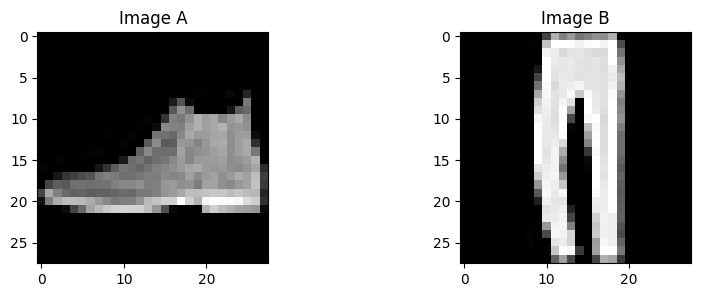

Distance entre A et B (Différents) : 0.0141
Distance entre A et A (Mêmes)      : 0.0000
Le modèle distingue bien les images !


In [24]:
def tester_distance(img1, img2, model):
    model.eval() # Mode évaluation
    with torch.no_grad(): 
        img1 = img1.unsqueeze(0).to(device)
        img2 = img2.unsqueeze(0).to(device)
        
        # On calcule les embeddings via le réseau d'embedding (pas le siamois complet)
        emb1 = embedding(img1)
        emb2 = embedding(img2)
        
        # Distance euclidienne
        dist = (emb1 - emb2).pow(2).sum(1).item()
        return dist

# Testons !
index_1 = 0 # Une botte (dans FashionMNIST test)
index_2 = 2 # Un pull
index_3 = 0 

img_a, label_a = test_data_raw[index_1] # Image A
img_b, label_b = test_data_raw[index_2] # Image B (Différente)
img_c, label_c = test_data_raw[index_1] # Image C (Identique à A)

# Affichage des images
plt.figure(figsize=(10,3))
plt.subplot(1,2,1); plt.imshow(img_a.squeeze(), cmap='gray'); plt.title("Image A")
plt.subplot(1,2,2); plt.imshow(img_b.squeeze(), cmap='gray'); plt.title("Image B")
plt.show()

dist_diff = tester_distance(img_a, img_b, model)
dist_same = tester_distance(img_a, img_c, model)

print(f"Distance entre A et B (Différents) : {dist_diff:.4f}")
print(f"Distance entre A et A (Mêmes)      : {dist_same:.4f}")

if dist_diff > dist_same:
    print("Le modèle distingue bien les images !")


Adaptation à la reconnaissance de visage.
Les difficulté : 
* Il faut un plus grand dataset
* Dans les dataset on a pas toujours plusieurs images de la meme personne
* Les images ne sont pas forcement en noir et blanc et aussi sont beacoup plus volumineuses
* C'est impossible d'entrainer le réseau complet sur un PC classique.


Nous allons faire d'abord faire une classe qui télécharge LFW (la base de donnée), filtre pour garder les personnes ayant au moins 2 photos, et enfin génère les triplet comme précédement.

In [28]:
from torchvision.datasets import ImageFolder

In [ ]:
transform_lfw=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) #Normalisation
])
lfw_raw = ImageFolder(root='data/archive/lfw-deepfunneled', transform=transform_lfw)

In [ ]:
class TripletLFW(Dataset):
    def __init__(self, dataset):
        
        self.dataset=dataset
        
        self.train_labels = [item[1] for item in self.dataset.imgs] #les labels des images
        
        self.labels_set = set(self.train_labels)# ensemble des labels uniques
        self.label_to_indices = {label: np.where(np.array(self.train_labels) == label)[0]
                                 for label in self.labels_set} # dictionnaire label: indices des images avec ce label
        
        #filtreage 
        self.valid_labels = [label for label in self.labels_set if len(self.label_to_indices[label]) >1]
        
        self.valid_indices = []
        for label in self.valid_labels:
            self.valid_indices.extend(self.label_to_indices[label])
            
            
        print (f"Nombre d'images utilisables : {len(self.valid_indices)}")
    def __getitem__(self, index):
        #Anchor (référence)
        real_index = self.valid_indices[index]
        img1, label1 = self.dataset[real_index]
            
            #Positif avec le meme label
        positive_index = real_index
        tentative=0
        while positive_index == real_index: #pour eviter de prendre la meme image
            positive_index = np.random.choice(self.label_to_indices[label1])
            tentative+=1
            if tentative>100:
                break
        img2, _ = self.dataset[positive_index]
            
            #Negatif avec un label different - utiliser uniquement les labels valides
        negative_label = np.random.choice(self.valid_labels)
        
        tentative=0
        while negative_label == label1:  # S'assurer que le label négatif est différent
            negative_label = np.random.choice(self.valid_labels)
            
            tentative +=1
            if tentative>100:
                break
        negative_index = np.random.choice(self.label_to_indices[negative_label]) #On prend une image avec ce label
        img3, _ = self.dataset[negative_index]
    
        return (img1, img2, img3) ,[] #le label n'est pas utilise dans le triplet loss

    def __len__(self): 
        return len(self.valid_indices) #nombre d'images valides dans le dataset
    
triplet_lfw_dataset = TripletLFW(lfw_raw)
triplet_lfw_loader=DataLoader(triplet_lfw_dataset, batch_size=32, shuffle=True, num_workers=0) #batch avec 32 triplets

Nombre d'images utilisables : 13233


# Transfert Learning:
Comme il sera très dur d'entrainer notre modèle, nous allons charger ResNet18 puis freez le réseau et on remplace la dernière couche par une nouvelle couche non-entrainée

In [78]:
import torchvision.models as models

In [79]:
class FaceNetResNet(nn.Module):
    def __init__(self):
        super(FaceNetResNet, self).__init__()
        # Utilisation d'un ResNet18 pré-entraîné

        self.resnet=models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        for param in self.resnet.parameters():
            param.requires_grad = False  # On gèle les poids du ResNet pré-entraîné


        # Remplacement de la couche finale pour obtenir un embedding de taille 128
        num_features = self.resnet.fc.in_features # Nombre de caractéristiques en entrée de la couche finale
        
        # Nouvelle couche finale dont la sortie est de taille 128
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.PReLU(),
            nn.Linear(256, 128)
        )
        
        # S'assurer que les nouvelles couches sont entraînables
        for param in self.resnet.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.resnet(x)
        return x
    
embedding_resnet=FaceNetResNet()
model_resnet = Siamois(embedding_resnet).to(device) #on réutilise la classe Siamois définie précédemment mais avec le nouvel embedding pré-entraîné

para_a_modifier=[]
for name, param in model_resnet.named_parameters():
    if param.requires_grad:
        para_a_modifier.append(param)
print(f"Nombre de paramètres à entraîner : {len(para_a_modifier)}")

Nombre de paramètres à entraîner : 5


In [80]:
critere_resnet = TripletLoss(marge=1.0).to(device)
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.0001)

In [ ]:
n_epoches = 3
model_resnet.train()

for epoch in range(n_epoches):
    running_loss = 0.0 #perte cumulée pour l'affichage
    for batch_index, (data,_) in enumerate(triplet_lfw_loader):
        (anchor, positive, negative)= data
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)#envoi des images au device (GPU)
        
        #remise à zero des gradients
        optimizer_resnet.zero_grad()
        
        anchor_out, positive_out, negative_out = model_resnet(anchor, positive, negative) #passage des images dans le réseau
        
         # Calcul de la perte
        
        loss = critere_resnet(anchor_out, positive_out, negative_out)
        loss.backward() #calcul des gradients backward utilise la fonction forward modifiée
        optimizer_resnet.step() #mise à jour des poids du modèle
        
         # Affichage des statistiques
        l=loss.item()
        running_loss += l
        if batch_index % 100 == 0:    # Afficher toutes les 100 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {batch_index }] loss: {l :.3f}')
    print(f'Epoch {epoch + 1} loss: {running_loss / len(triplet_lfw_loader):.3f}')
    


[Epoch 1, Batch 0] loss: 1.507
[Epoch 1, Batch 100] loss: 1.138
[Epoch 1, Batch 200] loss: 0.952


KeyboardInterrupt: 

# Test et affichage

In [ ]:
def denormaliser(tensor):
    tensor = tensor.clone()  # Crée une copie pour éviter de modifiwither l'original
    #Inversion de la normalisation appliquée lors du pré-traitement
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1) 
    std = torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)  # S'assure que les valeurs sont entre 0 et 1
    return tensor.permute(1, 2, 0).cpu().numpy()# Convertit le tenseur en format numpy pour affichage avec matplotlib

def evaluer_paire(img1,img2,model,threshold=1.0):
    model.eval()
    
    img1_batch=img1.unsqueeze(0).to(device)
    img2_batch=img2.unsqueeze(0).to(device)
    
    with torch.no_grad():
        emb1=model.embedding_resnet(img1_batch)
        emb1=model.embedding_resnet(img2_batch)
        
        
        distance = (emb1-emb2).pow(2).sum(1).sqrt().item()
        
        
    meme = distance<threshold
    
    color ="green" if meme else "red"
    
    decision= "même personne" if meme else "personnes différentes"
    
    
    plt.figure()
    plt.subplot(1,2)
    
    plt.imshow(denormaliser(img1))
    plt.set_title("Image 1")
    
    
    plt.subplot(2,2)
    plt.imshow(denormaliser(img2))
    plt.set_title("Image 2")
    
    plt.title(f"Distance : {distance:.4f}\nSeuil : {threshold} -> Verdict : {decisioon}", 
                 color=color)
    

In [ ]:
import random

#meme personnes

label_idx = random.choice(triplet_lfw_dataset.valid_labels) # On prend une personne au hasard
indices = triplet_lfw_dataset.label_to_indices[label_idx]

# On prend 2 photos différentes de cette personne
idx1, idx2 = random.sample(indices, 2)


img_same_1, _ = lfw_raw[idx1]
img_same_2, _ = lfw_raw[idx2]

print("TEST 1 : Devrait être la MÊME personne")
evaluer_paire(img_same_1, img_same_2, model, threshold=0.8)


# On prend deux personnes différentes
label_a = random.choice(triplet_lfw_dataset.valid_labels)
label_b = random.choice(triplet_lfw_dataset.valid_labels)
while label_a == label_b:
    label_b = random.choice(triplet_lfw_dataset.valid_labels)
# On prend une photo de chacun
idx_a = random.choice(triplet_lfw_dataset.label_to_indices[label_a])
idx_b = random.choice(triplet_lfw_dataset.label_to_indices[label_b])

img_diff_1, _ = lfw_raw[idx_a]
img_diff_2, _ = lfw_raw[idx_b]

print("TEST 2 : Devrait être des personnes DIFFÉRENTES")
evaluer_paire(img_diff_1, img_diff_2, model, threshold=0.8)

